# Volcano Detection on Venus
## CS 684 Final Project
### Si Ao Chen, Qi Mai


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
from google.colab import drive
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from xgboost import XGBClassifier, XGBRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor


Using TensorFlow backend.


In [ ]:
#must indicate that header is none so that pd won't treat the first image as the header
x_test = pd.read_csv("test_images.csv", header = None)
x_train = pd.read_csv("train_images.csv", header = None)
y_test = pd.read_csv("test_labels.csv")
y_train = pd.read_csv("train_labels.csv")

In [ ]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(7000, 12100)
(7000, 4)
(2734, 12100)
(2734, 4)


In [ ]:
np.count_nonzero(x_train.isnull() == True)
#no missing value in x_train

0

In [ ]:
x_train.head()

#each row represents an image

,0,1,2,3,4,5,6,7,8,9,...,12090,12091,12092,12093,12094,12095,12096,12097,12098,12099
0,95,101,99,103,95,86,96,89,70,104,...,111,107,92,89,103,99,117,116,118,96
1,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
2,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
3,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
4,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115


In [ ]:
y_train.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


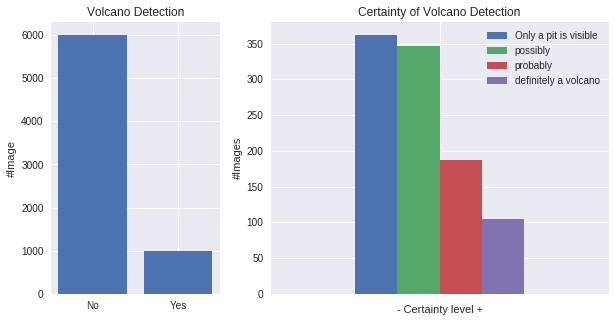

In [ ]:
# Visualize the certainty of volcano detection

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5),
                         gridspec_kw = {'width_ratios':[1, 2]})

isVolcano = y_train['Volcano?'].values
x_axis = np.array(['Yes', 'No'])
y_axis = np.array([np.count_nonzero(isVolcano == 1), np.count_nonzero(isVolcano==0)])

axes[0].bar(x_axis,y_axis)
axes[0].set_title('Volcano Detection')
axes[0].set_ylabel('#Image')

val = np.transpose(pd.DataFrame(y_train['Type'].value_counts()))
val.columns = ['Only a pit is visible', 'possibly', 'probably', 'definitely a volcano']

val.plot(kind = 'bar', rot = 0, ax=axes[1])
axes[1].set_xticklabels('')
plt.title('Certainty of Volcano Detection')
ylabel = plt.ylabel('#Images')
xlabel = plt.xlabel(' - Certainty level + ')

Text(0,0.5,'#Images')

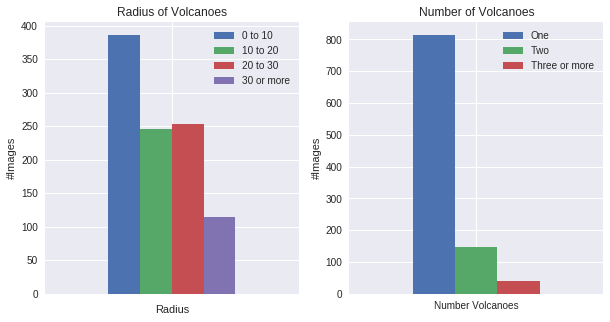

In [ ]:
# Visualize the distribution of images with different number of volcanoes and different radius of volcanoes

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

val = np.transpose(pd.DataFrame(y_train['Radius'].value_counts(bins = np.arange(0,91,10), sort = False).tolist()))
val['30 or higher'] = val.iloc[:,3:].sum(axis = 1)
val = val.drop(val.iloc[:,3:-1], axis = 1)
val.columns = ['0 to 10', '10 to 20', '20 to 30', '30 or more']

val.plot(kind='bar',ax=axes[0], title='Radius of Volcanoes')
axes[0].set_ylabel('#Images')
axes[0].set_xticklabels('')
axes[0].set_xlabel('Radius')

val = pd.DataFrame([y_train['Number Volcanoes'].value_counts()])
val.columns = ['One', 'Two', 'Three', 'Four', 'Five']
val['Three or more'] = val.iloc[:, 2:].sum(axis = 1)
val = val.drop(val.iloc[:,2:-1], axis = 1)

val.plot(kind = 'bar', rot = 0, ax=axes[1], title='Number of Volcanoes')
axes[1].set_ylabel('#Images')

In [ ]:
#resize x data
x_train = np.array(x_train).reshape(x_train.shape[0], 110,110)
x_test = np.array(x_test).reshape(x_test.shape[0], 110,110)

# rescale the image to (0,1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

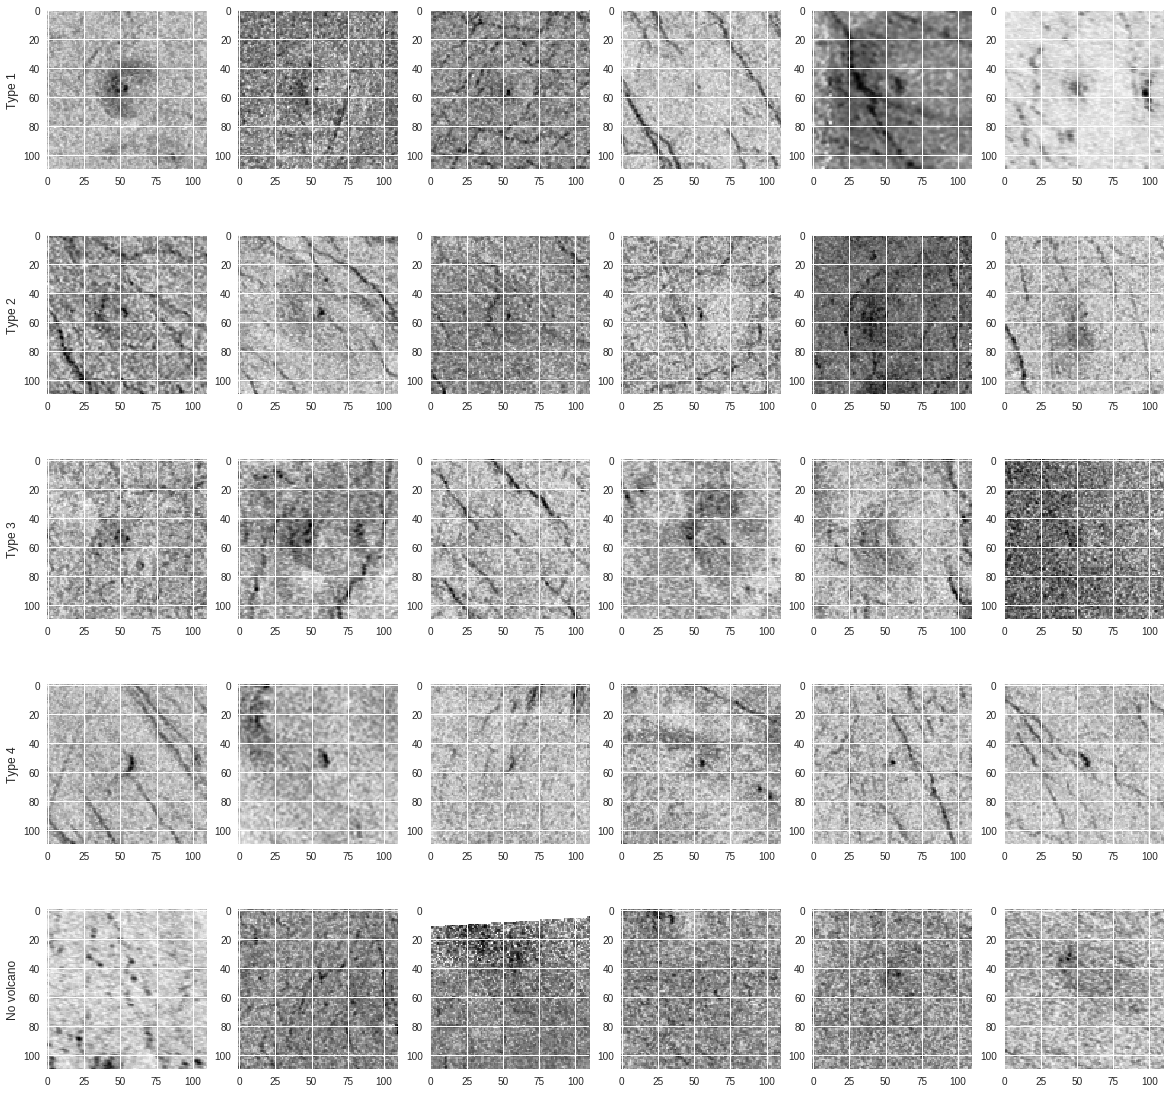

In [ ]:
#visualize volcano images

fig, ax = plt.subplots(5,6, figsize = (20,20))

#the images with volcanoes

for i in range(0,4):
  ind = y_train[y_train['Type'] == i+1].index[0:6]
  for j in range(len(ind)):
    ax[i][j].imshow(x_train[ind[j]])

#no volcanos
ind = y_train[y_train['Type'].isnull()].index[0:6]

for i in range(len(ind)):
  ax[4][i].imshow(x_train[ind[i]])

rows = ['Type 1', 'Type 2', 'Type 3', 'Type 4', 'No volcano']
for a, row in zip(ax[:,0], rows):
    a.set_ylabel(row, size='large')

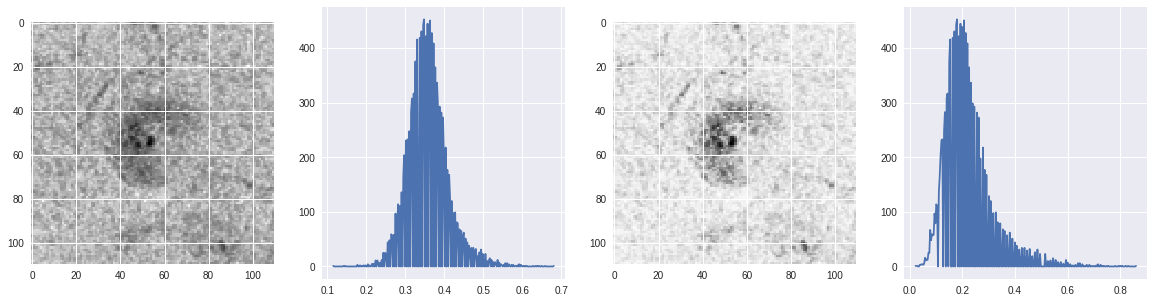

In [ ]:
# histogram equalization / contrast enhancement
from skimage import img_as_float
import skimage.exposure as expo

ind = y_train[y_train['Type'] == 1].index[0]
img = x_train[ind]

fig, ax = plt.subplots(1, 4, figsize = (20,5))
ax[0].imshow(img)
histo, bins = expo.histogram(img)
ax[1].plot(bins, histo)
img = expo.adjust_sigmoid(img,0.5)
ax[2].imshow(img)
histo, bins = expo.histogram(img)
ax[3].plot(bins, histo)


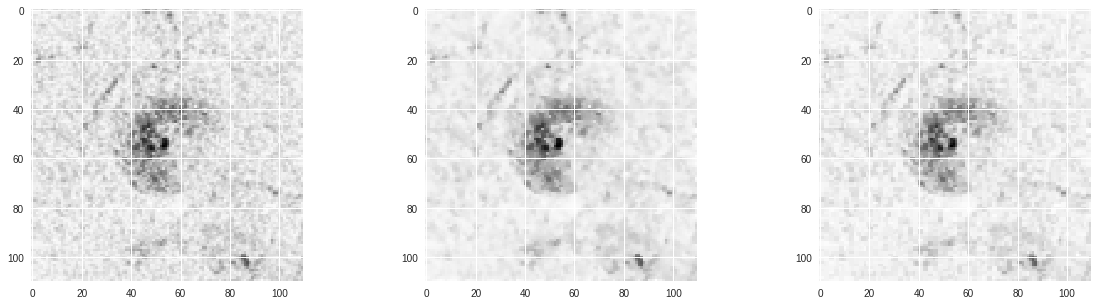

In [ ]:
# denoising

import skimage.restoration as res

fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(img)
ax[1].imshow(res.denoise_bilateral(img, multichannel=False))
ax[2].imshow(res.denoise_wavelet(img, multichannel=False))

## Corrupted Image Removal

In [ ]:
x_train = x_train.reshape((np.append(x_train.shape, 1)))
x_test = x_test.reshape((np.append(x_test.shape, 1)))

In [ ]:
# remove the corrupted images
# We pick small areas at the corners and see if any of them is all black
k1 = np.zeros((110,110),dtype=int)
k1[:5,:5] = 1
k2 = np.zeros((110,110),dtype=int)
k2[:5,105:] = 1
k3 = np.zeros((110,110),dtype=int)
k3[105:,:5] = 1
k4 = np.zeros((110,110),dtype=int)
k4[105:,105:] = 1

train_num = x_train.shape[0]
idx_corrupted = []
for i in range(train_num):
  a = np.sum(x_train[i,:,:,0]*k1)==0
  b = np.sum(x_train[i,:,:,0]*k2)==0
  c = np.sum(x_train[i,:,:,0]*k3)==0
  d = np.sum(x_train[i,:,:,0]*k4)==0
  if np.any([a,b,c,d]):
    idx_corrupted.append(i)

idx_corrupted = np.array(idx_corrupted)

In [ ]:
x_train = np.delete(x_train,idx_corrupted,axis=0)
print(x_train.shape)

(6741, 110, 110, 1)


In [ ]:
y_train = np.array(y_train,dtype='float')
y_test = np.array(y_test,dtype='float')
print(y_train[:5,:])

[[ 1.    3.   17.46  1.  ]
 [ 0.     nan   nan   nan]
 [ 0.     nan   nan   nan]
 [ 0.     nan   nan   nan]
 [ 0.     nan   nan   nan]]


In [ ]:
y_train = np.delete(y_train, idx_corrupted, axis=0)
print(y_train.shape)

(6741, 4)


## Volcano detection (binary classification)

In [ ]:
y_train_det = y_train[:,0]
y_train_det = y_train_det.astype('int64')
y_test_det = y_test[:,0]
y_test_det = y_test_det.astype('int64')
print(y_train_det[:5])
print(y_test_det[:5])

[1 0 0 0 0]
[0 0 1 0 1]


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import BatchNormalization as BN
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def report(model, y_test):
    pred = model.predict_classes(x_test)
    print('Model Performance:', '\n', classification_report(y_test, pred))
    print('test accuracy:', accuracy_score(y_test, pred))
    

def plot_process(history):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    
    ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('loss vs epoch')

    ax[1].plot(history.epoch, history.history['acc'], color='b', label="Training accuracy")
    ax[1].plot(history.epoch, history.history['val_acc'], color='r',label="Validation accuracy")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('accuracy vs epoch')

In [ ]:
from sklearn.utils import class_weight as get_weight

class_weight = get_weight.compute_class_weight('balanced',np.unique(y_train_det),y_train_det)
print(class_weight)

class_weight2 = {}
for i in range(2):
  class_weight2[i] = class_weight[i]/np.min(class_weight)
print(class_weight2)

[0.58566464 3.418357  ]
{0: 1.0, 1: 5.836713995943205}


In [ ]:
init = keras.initializers.RandomNormal(mean=0, stddev=0.5)
init_bias = keras.initializers.RandomNormal(mean=0, stddev=1)

model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3),kernel_initializer=init, bias_initializer=init_bias,
                 activation = 'relu', input_shape = (110,110,1)))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BN())
model.add(Dense(1, activation = 'sigmoid'))

sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss = 'binary_crossentropy', 
              optimizer = sgd, metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_good, batch_size = 128, verbose = 1, epochs = 25, 
                   validation_data = (x_test,y_test_det), class_weight = class_weight2)
model.save('model_1.h5')

Train on 6741 samples, validate on 2734 samples
Epoch 1/25
6741/6741 [==============================] - 14s 2ms/step - loss: 0.7589 - acc: 0.7382 - val_loss: 2.5578 - val_acc: 0.8413
Epoch 2/25
6741/6741 [==============================] - 8s 1ms/step - loss: 0.3733 - acc: 0.9143 - val_loss: 1.9709 - val_acc: 0.8413
Epoch 3/25
6741/6741 [==============================] - 8s 1ms/step - loss: 0.2580 - acc: 0.9507 - val_loss: 0.9109 - val_acc: 0.8420
Epoch 4/25
6741/6741 [==============================] - 8s 1ms/step - loss: 0.1929 - acc: 0.9637 - val_loss: 0.3991 - val_acc: 0.8731
Epoch 5/25
6741/6741 [==============================] - 8s 1ms/step - loss: 0.1300 - acc: 0.9786 - val_loss: 0.2440 - val_acc: 0.9181
Epoch 6/25
6741/6741 [==============================] - 8s 1ms/step - loss: 0.1015 - acc: 0.9840 - val_loss: 0.1376 - val_acc: 0.9477
Epoch 7/25
6741/6741 [==============================] - 8s 1ms/step - loss: 0.0757 - acc: 0.9883 - val_loss: 0.1014 - val_acc: 0.9704
Epoch 8/25
67

In [ ]:
report(model, y_test_det)

Model Performance: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      2300
           1       0.95      0.91      0.93       434

   micro avg       0.98      0.98      0.98      2734
   macro avg       0.97      0.95      0.96      2734
weighted avg       0.98      0.98      0.98      2734

test accuracy: 0.9776883686905633


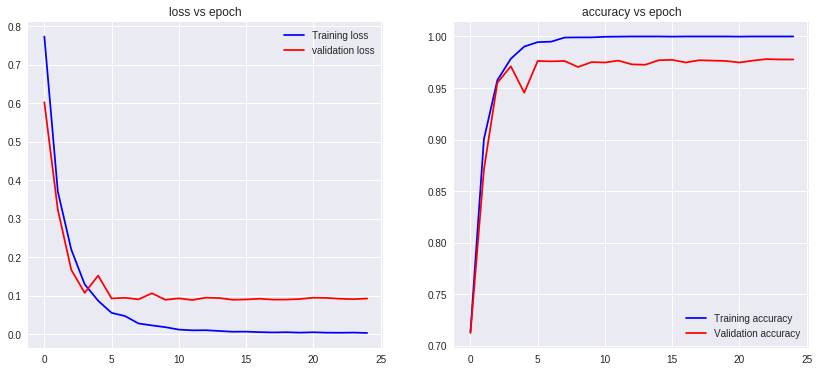

In [ ]:
plot_process(history)

## Oversampling using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# we need to reshape back to 2D for smote
x_train_copy = np.copy(x_train)
x_train_cpoy = x_train_copy.reshape((x_train.shape[0],110**2))

sm = SMOTE(random_state=2)
x_bal, y_bal = sm.fit_resample(x_train_cpoy, y_train_det)
print('Resampled dataset shape %s' % Counter(y_bal))

Resampled dataset shape Counter({1: 5755, 0: 5755})


In [ ]:
# reshape 
x_bal = x_bal.reshape((x_bal.shape[0],110,110,1))

In [ ]:
model_bal = keras.models.clone_model(model)

model_bal.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

history_bal = model_bal.fit(x_bal, y_bal, batch_size = 128, verbose = 1, epochs = 10, 
                   validation_data = (x_test,y_test_det))
#model_bal.save('model_1.h5')

Train on 11510 samples, validate on 2734 samples
Epoch 1/10
11510/11510 [==============================] - 15s 1ms/step - loss: 0.2480 - acc: 0.9006 - val_loss: 0.1938 - val_acc: 0.9320
Epoch 2/10
11510/11510 [==============================] - 13s 1ms/step - loss: 0.0748 - acc: 0.9773 - val_loss: 0.1523 - val_acc: 0.9477
Epoch 3/10
11510/11510 [==============================] - 13s 1ms/step - loss: 0.0391 - acc: 0.9918 - val_loss: 0.1292 - val_acc: 0.9601
Epoch 4/10
11510/11510 [==============================] - 13s 1ms/step - loss: 0.0225 - acc: 0.9962 - val_loss: 0.1240 - val_acc: 0.9660
Epoch 5/10
11510/11510 [==============================] - 13s 1ms/step - loss: 0.0139 - acc: 0.9992 - val_loss: 0.1131 - val_acc: 0.9696
Epoch 6/10
11510/11510 [==============================] - 14s 1ms/step - loss: 0.0099 - acc: 0.9997 - val_loss: 0.1182 - val_acc: 0.9663
Epoch 7/10
11510/11510 [==============================] - 13s 1ms/step - loss: 0.0076 - acc: 0.9997 - val_loss: 0.1191 - val_acc:

In [ ]:
report(model_bal, y_test_det)

Model Performance: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2300
           1       0.96      0.82      0.88       434

   micro avg       0.96      0.96      0.96      2734
   macro avg       0.96      0.90      0.93      2734
weighted avg       0.96      0.96      0.96      2734

test accuracy: 0.9648866130212144


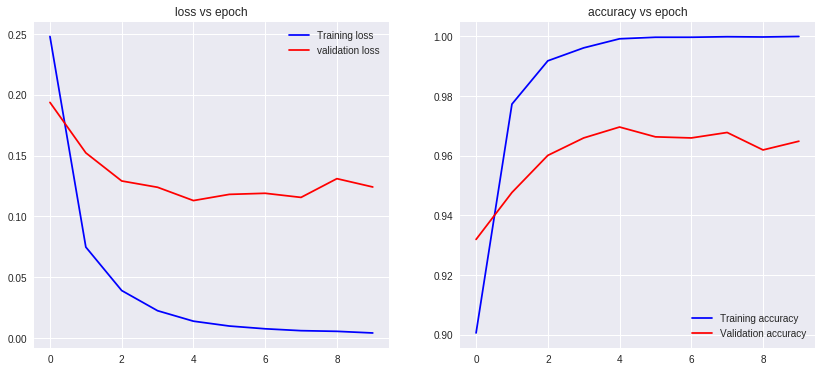

In [ ]:
plot_process(history_bal)

## Predict Certainty
### Using class weights

In [ ]:
y_train5 =y_train[:,1]
y_train5[np.isnan(y_train5)] = 0
print(y_train5.shape)

class_weights = get_weight.compute_class_weight('balanced',np.unique(y_train5),y_train5)
print(class_weights)

class_weight5 = {}
for i in range(5):
  class_weight5[i] = class_weights[i]
print(class_weight5)

y_test5 = y_test[:,1]
y_test5[np.isnan(y_test5)] = 0

y_train5 = to_categorical(y_train5, 5)
y_test5 = to_categorical(y_test5, 5)

(6741,)
[ 0.23426586 12.96346154  7.28756757  3.91918605  3.81926346]
{0: 0.23426585577758471, 1: 12.963461538461539, 2: 7.287567567567567, 3: 3.9191860465116277, 4: 3.8192634560906518}


In [ ]:
model_cert = keras.models.clone_model(model)

hidden = Dense(5, activation='softmax', name='dense_cert')(model_cert.layers[-2].output)
model_cert = keras.models.Model(model_cert.input, hidden)

model_cert.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
history_cert = model_cert.fit(x_train, y_train5, batch_size = 128, verbose = 1, epochs = 50, 
                   validation_data = (x_test,y_test5), class_weight = class_weight5)

Train on 6741 samples, validate on 2734 samples
Epoch 1/50
6741/6741 [==============================] - 10s 1ms/step - loss: 1.8044 - acc: 0.2525 - val_loss: 1.4456 - val_acc: 0.6079
Epoch 2/50
6741/6741 [==============================] - 8s 1ms/step - loss: 1.2336 - acc: 0.4281 - val_loss: 1.3436 - val_acc: 0.5351
Epoch 3/50
6741/6741 [==============================] - 8s 1ms/step - loss: 0.8667 - acc: 0.6336 - val_loss: 1.6483 - val_acc: 0.5066
Epoch 4/50
6741/6741 [==============================] - 8s 1ms/step - loss: 0.6160 - acc: 0.7201 - val_loss: 0.8681 - val_acc: 0.7670
Epoch 5/50
6741/6741 [==============================] - 8s 1ms/step - loss: 0.4260 - acc: 0.8115 - val_loss: 0.7910 - val_acc: 0.7849
Epoch 6/50
6741/6741 [==============================] - 8s 1ms/step - loss: 0.2728 - acc: 0.8668 - val_loss: 0.6196 - val_acc: 0.8252
Epoch 7/50
6741/6741 [==============================] - 8s 1ms/step - loss: 0.1878 - acc: 0.9016 - val_loss: 0.5237 - val_acc: 0.8383
Epoch 8/50
67

In [ ]:
def report3(model, x_test, y_test, num_class):
    pred = model.predict(x_test)
    pred = np.argmax(pred, axis=1)
    pred = to_categorical(pred, num_class)
    print('Model Performance:', '\n', classification_report(y_test, pred))
    print('test accuracy:', accuracy_score(y_test, pred))

In [ ]:
report3(model_cert, x_test, y_test5, 5)

Model Performance: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2300
           1       0.21      0.20      0.21        35
           2       0.31      0.19      0.24        88
           3       0.47      0.51      0.49       148
           4       0.72      0.79      0.75       163

   micro avg       0.91      0.91      0.91      2734
   macro avg       0.54      0.53      0.53      2734
weighted avg       0.90      0.91      0.90      2734

test accuracy: 0.9078273591806877


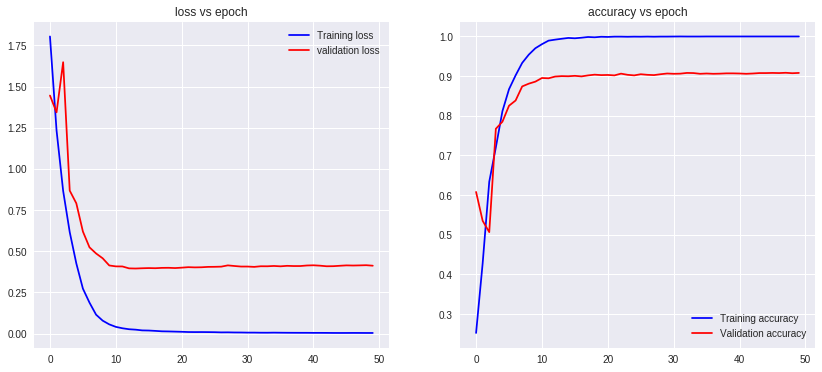

In [ ]:
plot_process(history_cert)

### Use oversampling

In [ ]:
sm = SMOTE(random_state=2)
x_cert_bal, y_cert_bal = sm.fit_resample(x_train_cpoy, np.argmax(y_train5,axis=1))
print('Resampled dataset shape %s' % Counter(y_cert_bal))

x_cert_bal = x_cert_bal.reshape((x_cert_bal.shape[0],110,110,1))
y_cert_bal = to_categorical(y_cert_bal,5)

Resampled dataset shape Counter({3: 5755, 0: 5755, 1: 5755, 4: 5755, 2: 5755})


In [ ]:
model_cert_bal = keras.models.clone_model(model)

hidden = Dense(5, activation='softmax', name='dense_cert')(model_cert_bal.layers[-2].output)
model_cert_bal = keras.models.Model(model_cert_bal.input, hidden)

model_cert_bal.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
history_cert_bal = model_cert_bal.fit(x_cert_bal, y_cert_bal, batch_size = 128, verbose = 1, epochs = 5, 
                   validation_data = (x_test,y_test5))

Train on 28775 samples, validate on 2734 samples
Epoch 1/5
28775/28775 [==============================] - 32s 1ms/step - loss: 0.4174 - acc: 0.8641 - val_loss: 0.3818 - val_acc: 0.8851
Epoch 2/5
28775/28775 [==============================] - 29s 1ms/step - loss: 0.0468 - acc: 0.9938 - val_loss: 0.3532 - val_acc: 0.8980
Epoch 3/5
28775/28775 [==============================] - 29s 1ms/step - loss: 0.0182 - acc: 0.9990 - val_loss: 0.3614 - val_acc: 0.8998
Epoch 4/5
28775/28775 [==============================] - 29s 1ms/step - loss: 0.0110 - acc: 0.9998 - val_loss: 0.3684 - val_acc: 0.8987
Epoch 5/5
28775/28775 [==============================] - 29s 1ms/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.3821 - val_acc: 0.9016


In [ ]:
report3(model_cert_bal, x_test, y_test5, 5)

Model Performance: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      2300
           1       0.27      0.23      0.25        35
           2       0.32      0.24      0.27        88
           3       0.46      0.28      0.35       148
           4       0.70      0.66      0.68       163

   micro avg       0.90      0.90      0.90      2734
   macro avg       0.54      0.48      0.50      2734
weighted avg       0.88      0.90      0.89      2734
 samples avg       0.90      0.90      0.90      2734

test accuracy: 0.901609363569861


## Data Augmentation

In [ ]:
from keras.regularizers import l2
init = keras.initializers.RandomNormal(mean=0, stddev=0.5)
init_bias = keras.initializers.RandomNormal(mean=0, stddev=1)
l2pen = 5*10**-3

model2 = Sequential()

model2.add(Conv2D(32, kernel_size = (3,3),kernel_initializer=init, bias_initializer=init_bias,
                 activation = 'relu', input_shape = (110,110,1), kernel_regularizer=l2(l2pen)))
model2.add(BN())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', kernel_regularizer=l2(l2pen)))
model2.add(BN())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

model2.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', kernel_regularizer=l2(l2pen)))
model2.add(BN())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

model2.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', kernel_regularizer=l2(l2pen)))
model2.add(BN())
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))

model2.add(Flatten())
model2.add(Dense(512, activation = 'relu'))
model2.add(BN())
model2.add(Dense(1, activation = 'sigmoid'))

sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
model2.compile(loss = 'binary_crossentropy', 
              optimizer = sgd, metrics = ['accuracy'])

In [ ]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    samplewise_std_normalization = True,
    horizontal_flip=True,
    vertical_flip = True,
    brightness_range = [0.8,1.2],
    zoom_range = [0.8,1]
)

datagen.fit(x_train)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:855: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
model_aug = keras.models.clone_model(model2)
model_aug.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
model_aug.fit_generator(datagen.flow(x_train, y_train_det, batch_size=128),
                    steps_per_epoch=len(x_train) / 128, epochs=10,
                   validation_data=(x_test,y_test_det), class_weight = class_weight2)

Epoch 1/10
53/52 [==============================] - 21s 400ms/step - loss: 2.3345 - acc: 0.7051 - val_loss: 3.9378 - val_acc: 0.1587
Epoch 2/10
53/52 [==============================] - 12s 226ms/step - loss: 1.9280 - acc: 0.8695 - val_loss: 3.2545 - val_acc: 0.1587
Epoch 3/10
53/52 [==============================] - 13s 241ms/step - loss: 1.7920 - acc: 0.9203 - val_loss: 2.5375 - val_acc: 0.1587
Epoch 4/10
53/52 [==============================] - 13s 240ms/step - loss: 1.7331 - acc: 0.9270 - val_loss: 2.4793 - val_acc: 0.1587
Epoch 5/10
53/52 [==============================] - 13s 241ms/step - loss: 1.6572 - acc: 0.9460 - val_loss: 2.2921 - val_acc: 0.1598
Epoch 6/10
53/52 [==============================] - 13s 240ms/step - loss: 1.6088 - acc: 0.9495 - val_loss: 1.8493 - val_acc: 0.8413
Epoch 7/10
53/52 [==============================] - 13s 239ms/step - loss: 1.5689 - acc: 0.9549 - val_loss: 1.7579 - val_acc: 0.8413
Epoch 8/10
53/52 [==============================] - 13s 239ms/step - 

In [ ]:
datagen.fit(x_bal)
generator = datagen.flow(x_bal, y_bal, batch_size=128)

model_aug_bal = keras.models.clone_model(model2)
model_aug_bal.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
model_aug_bal.fit_generator(generator,
                    steps_per_epoch=len(x_bal) / 128, epochs=20,
                   validation_data=(x_test,y_test_det))

Epoch 1/20
90/89 [==============================] - 25s 282ms/step - loss: 1.7006 - acc: 0.8685 - val_loss: 2.9612 - val_acc: 0.1847
Epoch 2/20
90/89 [==============================] - 21s 229ms/step - loss: 1.4976 - acc: 0.9476 - val_loss: 2.8188 - val_acc: 0.1613
Epoch 3/20
90/89 [==============================] - 21s 236ms/step - loss: 1.4244 - acc: 0.9574 - val_loss: 2.0644 - val_acc: 0.2758
Epoch 4/20
90/89 [==============================] - 21s 236ms/step - loss: 1.3611 - acc: 0.9664 - val_loss: 2.4646 - val_acc: 0.1587
Epoch 5/20
90/89 [==============================] - 21s 236ms/step - loss: 1.3097 - acc: 0.9680 - val_loss: 1.9586 - val_acc: 0.1909
Epoch 6/20
90/89 [==============================] - 21s 235ms/step - loss: 1.2557 - acc: 0.9731 - val_loss: 1.9409 - val_acc: 0.1650
Epoch 7/20
90/89 [==============================] - 21s 235ms/step - loss: 1.2108 - acc: 0.9725 - val_loss: 1.7547 - val_acc: 0.7952
Epoch 8/20
90/89 [==============================] - 21s 236ms/step - 

In [ ]:
report(model_aug_bal, y_test_det)

Model Performance: 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      2300
           1       0.00      0.00      0.00       434

   micro avg       0.84      0.84      0.84      2734
   macro avg       0.42      0.50      0.46      2734
weighted avg       0.71      0.84      0.77      2734

test accuracy: 0.8412582297000731


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Transfer learning: use trained VGG16

### VGG16 for volcano detection (class weight version)

In [ ]:
x_train_3chan = np.repeat(x_train,3,axis=3)
print(x_train_3chan.shape)
x_test_3chan = np.repeat(x_test,3,axis=3)

(6741, 110, 110, 3)


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

vgg = VGG16(include_top=False, input_shape=(110,110,3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
last_layer = vgg.output

x = Flatten()(last_layer)
x = Dense(512, activation='relu')(x)
x = BN()(x)
vgg_base = Dense(1, activation = 'sigmoid')(x)

vgg.trainable = False

vgg_model = Model(vgg.input, vgg_base)

sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.95, nesterov=True)
vgg_model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
vgg_history = vgg_model.fit(x_train_3chan, y_train_det, batch_size = 128, verbose=1, epochs=30,
                   validation_data = (x_test_3chan, y_test_det), class_weight = class_weight2)

Train on 6741 samples, validate on 2734 samples
Epoch 1/30
6741/6741 [==============================] - 69s 10ms/step - loss: 0.7287 - acc: 0.7503 - val_loss: 13.4117 - val_acc: 0.1587
Epoch 2/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.3922 - acc: 0.9064 - val_loss: 0.3030 - val_acc: 0.9148
Epoch 3/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.2752 - acc: 0.9418 - val_loss: 0.5704 - val_acc: 0.7315
Epoch 4/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.2199 - acc: 0.9576 - val_loss: 0.8971 - val_acc: 0.8756
Epoch 5/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.1777 - acc: 0.9683 - val_loss: 0.2964 - val_acc: 0.9225
Epoch 6/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.1370 - acc: 0.9734 - val_loss: 0.7165 - val_acc: 0.6642
Epoch 7/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.1189 - acc: 0.9782 - val_loss: 0.1559 - val_acc: 0.9557
Epoch

In [ ]:
def report2(model, y_test):
    pred = model.predict(x_test_3chan)
    pred = (pred-0.5>0).astype('int')
    print('Model Performance:', '\n', classification_report(y_test, pred))
    print('test accuracy:', accuracy_score(y_test, pred))

In [ ]:
report2(vgg_model, y_test_det)

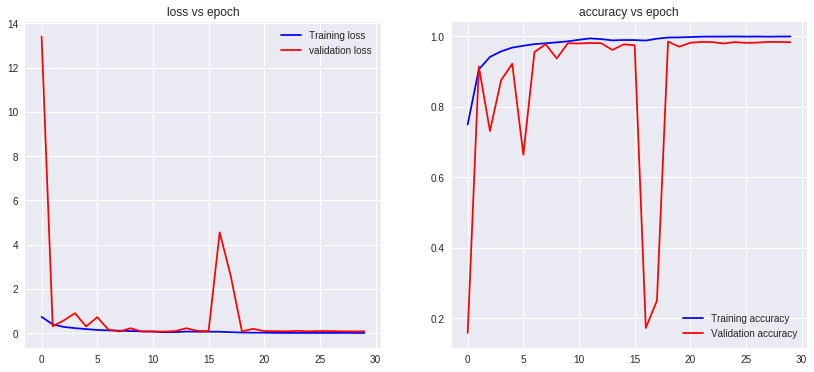

In [ ]:
plot_process(vgg_history)

### VGG16 for volcano detection (oversampling version)
### conclusion: overfitting

In [ ]:
x_bal_3chan = np.repeat(x_bal,3,axis=3)
print(x_bal_3chan.shape)

(11510, 110, 110, 3)


In [ ]:
vgg_bal = keras.models.clone_model(vgg_model)
vgg_bal.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])

vgg_bal_history = vgg_bal.fit(x_bal_3chan, y_bal, batch_size = 128, verbose=1, epochs=20,
                   validation_data = (x_test_3chan, y_test_det))

Train on 11510 samples, validate on 2734 samples
Epoch 1/20
11510/11510 [==============================] - 86s 7ms/step - loss: 0.6535 - acc: 0.6991 - val_loss: 0.5505 - val_acc: 0.7908
Epoch 2/20
11510/11510 [==============================] - 84s 7ms/step - loss: 0.3863 - acc: 0.8515 - val_loss: 1.5097 - val_acc: 0.8186
Epoch 3/20
11510/11510 [==============================] - 84s 7ms/step - loss: 0.2236 - acc: 0.9218 - val_loss: 1.6392 - val_acc: 0.8178
Epoch 4/20
11510/11510 [==============================] - 84s 7ms/step - loss: 0.1589 - acc: 0.9469 - val_loss: 1.5303 - val_acc: 0.8160
Epoch 5/20
11510/11510 [==============================] - 84s 7ms/step - loss: 0.1294 - acc: 0.9559 - val_loss: 0.6083 - val_acc: 0.8742
Epoch 6/20
11510/11510 [==============================] - 84s 7ms/step - loss: 0.1055 - acc: 0.9645 - val_loss: 5.8732 - val_acc: 0.1650
Epoch 7/20
11510/11510 [==============================] - 84s 7ms/step - loss: 0.0909 - acc: 0.9700 - val_loss: 0.6923 - val_acc:

In [ ]:
report2(vgg_bal, y_test_det)

Model Performance: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.97      2300
           1       0.79      0.90      0.84       434

   micro avg       0.95      0.95      0.95      2734
   macro avg       0.88      0.93      0.90      2734
weighted avg       0.95      0.95      0.95      2734

test accuracy: 0.9455010972933431


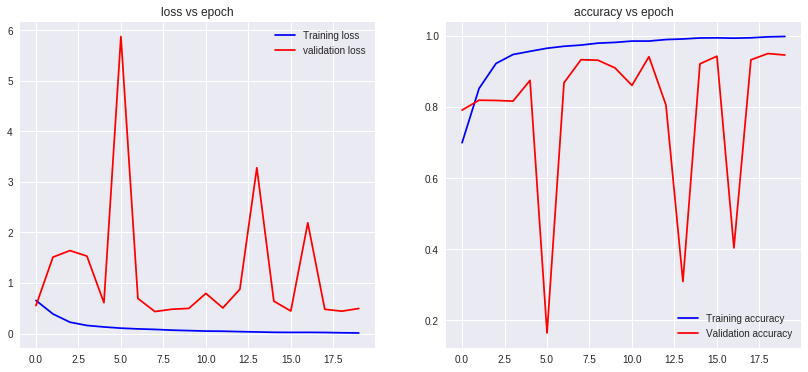

In [ ]:
plot_process(vgg_bal_history)

## VGG for Certainty

In [ ]:
y_clean = y_train[:,1]
print(y_clean.shape)

y_clean[np.isnan(y_clean)] = 0
y_certainty_train = y_clean
x_certainty_train = x_train_3chan
print(y_certainty_train.shape)
print(x_certainty_train.shape)

y_certainty_test = np.array(y_test)[:,1]
y_certainty_test[np.isnan(y_certainty_test)] = 0
x_certainty_test = x_test_3chan

print(y_certainty_test.shape)
print(x_certainty_test.shape)

(6741,)
(6741,)
(6741, 110, 110, 3)
(2734,)
(2734, 110, 110, 3)


In [ ]:
type_weights = get_weight.compute_class_weight('balanced',np.unique(y_certainty_train),y_certainty_train)
print(type_weights)

type_weights1 = {}
for i in range(5):
  type_weights1[i] = type_weights[i]
print(type_weights1)

[ 0.23426586 12.96346154  7.28756757  3.91918605  3.81926346]
{0: 0.23426585577758471, 1: 12.963461538461539, 2: 7.287567567567567, 3: 3.9191860465116277, 4: 3.8192634560906518}


In [ ]:
vgg_certainty = VGG16(include_top=False, input_shape=(110,110,3))
last_layer = vgg_certainty.output

x = Flatten()(last_layer)
x = Dense(512, activation='relu')(x)
x = BN()(x)
vgg_base = Dense(5, activation = 'softmax')(x)

vgg_certainty.trainable = False

model_certainty = Model(vgg_certainty.input, vgg_base)

sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.95, nesterov=True)
model_certainty.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = [keras.metrics.categorical_accuracy])

In [ ]:
y_certainty_train = keras.utils.to_categorical(y_certainty_train, 5)
y_certainty_test = keras.utils.to_categorical(y_certainty_test, 5)

In [ ]:
vgg_history = model_certainty.fit(x_certainty_train, y_certainty_train, batch_size = 128, verbose=1, epochs=30,
                   validation_data = (x_certainty_test, y_certainty_test), class_weight = type_weights1)

Train on 6741 samples, validate on 2734 samples
Epoch 1/30
6741/6741 [==============================] - 59s 9ms/step - loss: 0.5043 - categorical_accuracy: 0.2098 - val_loss: 6.2057 - val_categorical_accuracy: 0.0322
Epoch 2/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.4739 - categorical_accuracy: 0.2743 - val_loss: 6.3300 - val_categorical_accuracy: 0.0128
Epoch 3/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.4442 - categorical_accuracy: 0.4461 - val_loss: 3.1427 - val_categorical_accuracy: 0.0421
Epoch 4/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.4314 - categorical_accuracy: 0.5186 - val_loss: 0.4398 - val_categorical_accuracy: 0.8325
Epoch 5/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.4125 - categorical_accuracy: 0.5570 - val_loss: 1.0179 - val_categorical_accuracy: 0.8413
Epoch 6/30
6741/6741 [==============================] - 52s 8ms/step - loss: 0.3929 - categorical_accuracy:

In [ ]:
pred = model_certainty.predict(x_certainty_test)
pred = np.argmax(pred, axis=1)
pred = to_categorical(pred, 5)
print('Model Performance:', '\n', classification_report(y_certainty_test, pred))
print('test accuracy:', accuracy_score(y_certainty_test, pred))

Model Performance: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2300
           1       0.35      0.34      0.35        35
           2       0.42      0.22      0.29        88
           3       0.44      0.64      0.52       148
           4       0.77      0.82      0.79       163

   micro avg       0.91      0.91      0.91      2734
   macro avg       0.59      0.60      0.59      2734
weighted avg       0.92      0.91      0.91      2734
 samples avg       0.91      0.91      0.91      2734

test accuracy: 0.9129480614484272


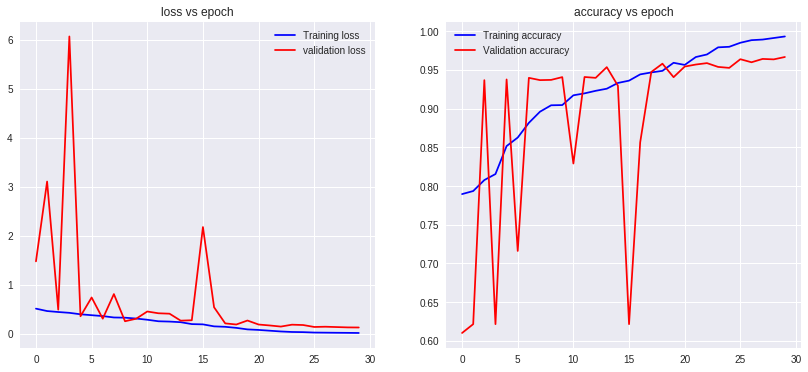

In [ ]:
plot_process(vgg_history)

## VGG on volcano numbers

In [ ]:
y_clean = y_train[:,3]
print(y_clean.shape)

y_clean[np.isnan(y_clean)] = 0
y_vn_train = y_clean
x_vn_train = x_train_3chan

#remove number of volcanoes more than 3 since it does not occur in test case
idx = np.where(y_vn_train>3)
y_vn_train = np.delete(y_vn_train, idx, axis=0)
x_vn_train = np.delete(x_vn_train, idx, axis=0)

print(y_vn_train.shape)
print(x_vn_train.shape)

y_vn_test = np.array(y_test)[:,3]
y_vn_test[np.isnan(y_vn_test)] = 0
x_vn_test = x_test_3chan

print(y_vn_test.shape)
print(x_vn_test.shape)

np.unique(y_vn_train)

(6741,)
(6732,)
(6732, 110, 110, 3)
(2734,)
(2734, 110, 110, 3)


array([0., 1., 2., 3.])

In [ ]:
vn_weights = get_weight.compute_class_weight('balanced',np.unique(y_vn_train),y_vn_train)
print(vn_weights)

vn_weights1 = {}
for i in range(4):
  vn_weights1[i] = vn_weights[i]
print(vn_weights1)

[ 0.29244136  2.09328358 11.60689655 60.10714286]
{0: 0.29244135534317983, 1: 2.093283582089552, 2: 11.606896551724137, 3: 60.107142857142854}


In [ ]:
vgg_vn = VGG16(include_top=False, input_shape=(110,110,3))
last_layer = vgg_vn.output

x = Flatten()(last_layer)
x = Dense(512, activation='relu')(x)
x = BN()(x)
vgg_base = Dense(4, activation = 'softmax')(x)

vgg_vn.trainable = False

model_vn = Model(vgg_vn.input, vgg_base)

sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.95, nesterov=True)
model_vn.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
y_vn_train = keras.utils.to_categorical(y_vn_train, 4)
y_vn_test = keras.utils.to_categorical(y_vn_test, 4)

In [ ]:
vgg_history = model_vn.fit(x_vn_train, y_vn_train, batch_size = 128, verbose=1, epochs=30,
                   validation_data = (x_vn_test, y_vn_test), class_weight = vn_weights1)

In [ ]:
pred = model_vn.predict(x_vn_test)
pred = np.argmax(pred, axis=1)
pred = to_categorical(pred, 4)
print('Model Performance:', '\n', classification_report(y_vn_test, pred))
print('test accuracy:', accuracy_score(y_vn_test, pred))

Model Performance: 
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      2300
           1       0.96      0.36      0.53       359
           2       0.18      0.37      0.24        63
           3       0.00      0.00      0.00        12

   micro avg       0.89      0.89      0.89      2734
   macro avg       0.52      0.43      0.43      2734
weighted avg       0.91      0.89      0.88      2734
 samples avg       0.89      0.89      0.89      2734

test accuracy: 0.8924652523774689


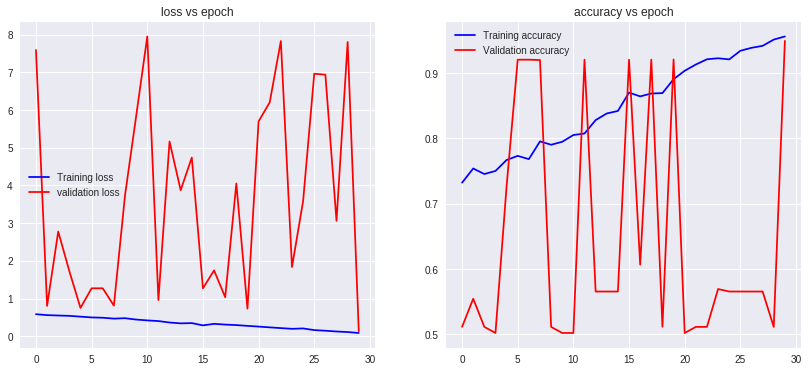

In [ ]:
plot_process(vgg_history)

## Predict the number of Volcanoes (0, 1, 2, 3)

In [ ]:
# uncomment the following line if the shape of y_train is (7000, 4)
# y_train = np.delete(np.array(y_train), idx_corrupted, axis=0)
print(y_train.shape)

(6741, 4)


In [ ]:
train_vol_num_all = y_train[:,3]
train_vol_num_all[np.isnan(train_vol_num_all)] = 0
train_vol_num_all = train_vol_num_all.astype('int')
print(np.unique(train_vol_num_all))

test_vol_num_all = y_test[:,3]
test_vol_num_all[np.isnan(test_vol_num_all)] = 0
test_vol_num_all = test_vol_num_all.astype('int')
print(np.unique(test_vol_num_all))

'''
We notice that there are no images containing more than 3 volcanoes in the 
test set, so we remove the images with more than 3 volcanoes from the 
training set.
'''

idx = np.where(train_vol_num_all>3)
print(idx)
train_vol_num_all = np.delete(train_vol_num_all, idx, axis=0)
x_train_vol_num_all = np.delete(x_train, idx, axis = 0)
print(x_train_vol_num_all.shape)

[0 1 2 3 4 5]
[0 1 2 3]
(array([ 407,  812,  955, 1018, 1456, 3810, 5358, 5465, 6624]),)
(6732, 110, 110, 1)


In [ ]:
volnum_weights4 = get_weight.compute_class_weight('balanced',np.unique(train_vol_num_all),train_vol_num_all)
print(volnum_weights4)

volnum_weight4 = {}
for i in range(4):
  volnum_weight4[i] = volnum_weights4[i]
print(volnum_weight4)

[ 0.29244136  2.09328358 11.60689655 60.10714286]
{0: 0.29244135534317983, 1: 2.093283582089552, 2: 11.606896551724137, 3: 60.107142857142854}


## CNN: class weight version

In [ ]:
model_volnum = keras.models.clone_model(model)

hidden = Dense(4, activation='softmax', name='dense_cert')(model_volnum.layers[-2].output)
model_volnum = keras.models.Model(model_volnum.input, hidden)

model_volnum.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
y_train_vol_num = keras.utils.to_categorical(train_vol_num_all, 4)
y_test_vol_num = keras.utils.to_categorical(test_vol_num_all, 4)

In [ ]:
history_vol_num = model_volnum.fit(x_train_vol_num_all, y_train_vol_num, batch_size = 128, verbose = 1, epochs = 40, 
                   validation_data = (x_test, y_test_vol_num), class_weight = volnum_weight4)

Train on 6732 samples, validate on 2734 samples
Epoch 1/40
6732/6732 [==============================] - 11s 2ms/step - loss: 1.8572 - acc: 0.2693 - val_loss: 11.7184 - val_acc: 0.0366
Epoch 2/40
6732/6732 [==============================] - 8s 1ms/step - loss: 1.4423 - acc: 0.4534 - val_loss: 2.6619 - val_acc: 0.3339
Epoch 3/40
6732/6732 [==============================] - 8s 1ms/step - loss: 0.9174 - acc: 0.6315 - val_loss: 1.6774 - val_acc: 0.5176
Epoch 4/40
6732/6732 [==============================] - 8s 1ms/step - loss: 0.7052 - acc: 0.7354 - val_loss: 0.3410 - val_acc: 0.9034
Epoch 5/40
6732/6732 [==============================] - 8s 1ms/step - loss: 0.6736 - acc: 0.8041 - val_loss: 0.4318 - val_acc: 0.8636
Epoch 6/40
6732/6732 [==============================] - 8s 1ms/step - loss: 0.4806 - acc: 0.8341 - val_loss: 0.5336 - val_acc: 0.8197
Epoch 7/40
6732/6732 [==============================] - 8s 1ms/step - loss: 0.4007 - acc: 0.8752 - val_loss: 0.3558 - val_acc: 0.8844
Epoch 8/40
6

In [ ]:
report3(model_volnum,x_test, y_test_vol_num,4)


Model Performance: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2300
           1       0.84      0.85      0.85       359
           2       0.28      0.24      0.26        63
           3       0.08      0.08      0.08        12

   micro avg       0.95      0.95      0.95      2734
   macro avg       0.55      0.54      0.54      2734
weighted avg       0.94      0.95      0.95      2734
 samples avg       0.95      0.95      0.95      2734

test accuracy: 0.9469641550841258


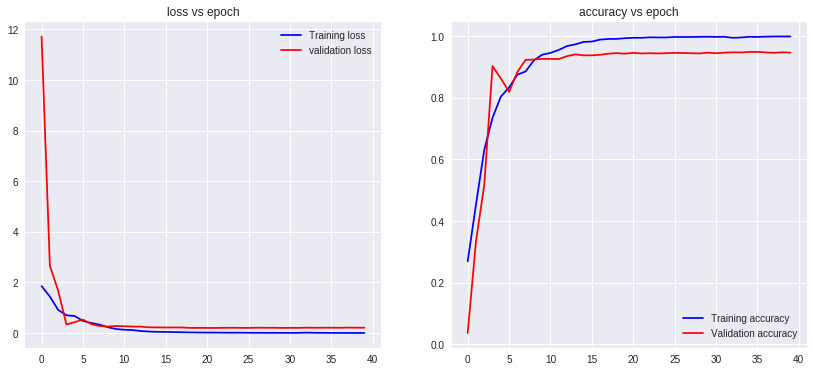

In [ ]:
plot_process(history_vol_num)

In [ ]:
# only consider the images with volcanoes
ind = np.where(test_vol_num_all>0)
a = np.argmax(y_test_vol_num,axis=1)[ind]
pred = model_volnum.predict(x_test[ind])
pred = np.argmax(pred,axis=1).astype('int')
b = pred
acc = np.sum(a==b)/a.shape[0]
print(acc)

0.7396313364055299


## CNN: oversampling version

In [ ]:
x_vn_bal = np.copy(x_train_vol_num_all)
x_vn_bal = x_vn_bal.reshape(x_vn_bal.shape[0],110**2)

sm = SMOTE(random_state=2)
x_vn_bal, y_vn_bal = sm.fit_resample(x_vn_bal, train_vol_num_all)
print('Resampled dataset shape %s' % Counter(y_vn_bal))

x_vn_bal = x_vn_bal.reshape((x_vn_bal.shape[0],110,110,1))
y_vn_bal = to_categorical(y_vn_bal,4)

Resampled dataset shape Counter({1: 5755, 0: 5755, 2: 5755, 3: 5755})


In [ ]:
model_vn_bal = keras.models.clone_model(model)

hidden = Dense(4, activation='softmax', name='dense_cert')(model_vn_bal.layers[-2].output)
model_vn_bal = keras.models.Model(model_vn_bal.input, hidden)

model_vn_bal.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
history_vn_bal = model_vn_bal.fit(x_vn_bal, y_vn_bal, batch_size = 128, verbose = 1, epochs = 10, 
                   validation_data = (x_test, y_test_vol_num))

Train on 23020 samples, validate on 2734 samples
Epoch 1/10
23020/23020 [==============================] - 28s 1ms/step - loss: 0.3421 - acc: 0.8851 - val_loss: 0.3252 - val_acc: 0.9071
Epoch 2/10
23020/23020 [==============================] - 24s 1ms/step - loss: 0.0485 - acc: 0.9911 - val_loss: 0.2679 - val_acc: 0.9312
Epoch 3/10
23020/23020 [==============================] - 24s 1ms/step - loss: 0.0179 - acc: 0.9984 - val_loss: 0.2623 - val_acc: 0.9338
Epoch 4/10
23020/23020 [==============================] - 24s 1ms/step - loss: 0.0095 - acc: 0.9996 - val_loss: 0.2678 - val_acc: 0.9375
Epoch 5/10
23020/23020 [==============================] - 24s 1ms/step - loss: 0.0059 - acc: 0.9998 - val_loss: 0.2812 - val_acc: 0.9367
Epoch 6/10
23020/23020 [==============================] - 24s 1ms/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.2847 - val_acc: 0.9386
Epoch 7/10
23020/23020 [==============================] - 24s 1ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.2985 - val_acc:

In [ ]:
history_vn_bal = model_vn_bal.fit(x_vn_bal, y_vn_bal, batch_size = 128, verbose = 1, epochs = 1, 
                   validation_data = (x_test, y_test_vol_num))

Train on 23020 samples, validate on 2734 samples
Epoch 1/1
23020/23020 [==============================] - 24s 1ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.3155 - val_acc: 0.9382


In [ ]:
report3(model_vn_bal,x_test, y_test_vol_num, 4)

Model Performance: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      2300
           1       0.83      0.75      0.79       359
           2       0.40      0.10      0.15        63
           3       0.00      0.00      0.00        12

   micro avg       0.94      0.94      0.94      2734
   macro avg       0.55      0.46      0.48      2734
weighted avg       0.92      0.94      0.93      2734
 samples avg       0.94      0.94      0.94      2734

test accuracy: 0.9381858083394294


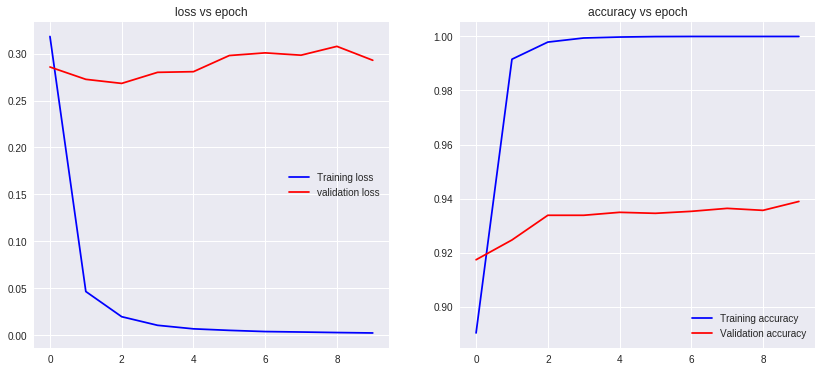

In [ ]:
plot_process(history_vn_bal)

In [ ]:
pred = model_vn_bal.predict(x_test[ind])
pred = np.argmax(pred,axis=1).astype('int')
b = pred
acc = np.sum(a==b)/a.shape[0]
print(acc)

0.6336405529953917


## CNN: predict the number of volcanoes (1,2,3)

In [ ]:
train_vol_num = y_train[y_train_det==1,3]
train_vol_num = train_vol_num.astype('int')
x_train_vol_num = x_train[y_train_det==1]
print(x_train_vol_num.shape)
print(train_vol_num.shape)
y_test = np.array(y_test)
test_vol = y_test[:,0]
test_vol_num = y_test[test_vol==1,3]
test_vol_num = test_vol_num.astype('int')
x_test_vol_num = x_test[test_vol==1]
print(x_test_vol_num.shape)
print(test_vol_num.shape)

(986, 110, 110, 1)
(986,)
(434, 110, 110, 1)
(434,)


In [ ]:
idx = np.where(train_vol_num>3)
print(idx)
train_vol_num = np.delete(train_vol_num, idx, axis=0)
x_train_vol_num = np.delete(x_train_vol_num, idx, axis = 0)
print(train_vol_num.shape)

(array([ 55, 103, 127, 136, 201, 538, 773, 793, 974]),)
(977,)


In [ ]:
volnum_weights = get_weight.compute_class_weight('balanced',np.unique(train_vol_num),train_vol_num)
print(volnum_weights)

[ 0.40505804  2.24597701 11.63095238]


In [ ]:
#using CNN model

init = keras.initializers.RandomNormal(mean=0, stddev=0.5)
init_bias = keras.initializers.RandomNormal(mean=0, stddev=1)

model_cnn = Sequential()

model_cnn.add(Conv2D(32, kernel_size = (3,3),kernel_initializer=init, bias_initializer=init_bias,
                 activation = 'relu', input_shape = (110,110,1)))
model_cnn.add(BN())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))

model_cnn.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model_cnn.add(BN())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))

model_cnn.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model_cnn.add(BN())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))

model_cnn.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model_cnn.add(BN())
model_cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))

model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation = 'relu'))
model_cnn.add(BN())
model_cnn.add(Dense(3, activation = 'softmax'))

sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
model_cnn.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, metrics = ['accuracy'])

In [ ]:
train_vol_num2 = keras.utils.to_categorical((train_vol_num-1), 3)
test_vol_num2 = keras.utils.to_categorical((test_vol_num-1), 3)

volnum_weight4 = {}
for i in range(3):
  volnum_weight4[i] = volnum_weights[i]
print(volnum_weight4)

{0: 0.4050580431177446, 1: 2.245977011494253, 2: 11.630952380952381}


In [ ]:
history_cnn = model_cnn.fit(x_train_vol_num, train_vol_num2, batch_size = 64, verbose = 1, epochs = 40, 
                   validation_data = (x_test_vol_num,test_vol_num2), class_weight = volnum_weight4)

Train on 977 samples, validate on 434 samples
Epoch 1/40
977/977 [==============================] - 3s 3ms/step - loss: 1.4874 - acc: 0.3756 - val_loss: 3.2389 - val_acc: 0.5023
Epoch 2/40
977/977 [==============================] - 1s 1ms/step - loss: 1.0045 - acc: 0.3900 - val_loss: 1.7853 - val_acc: 0.5530
Epoch 3/40
977/977 [==============================] - 1s 1ms/step - loss: 0.6862 - acc: 0.4770 - val_loss: 1.7838 - val_acc: 0.3203
Epoch 4/40
977/977 [==============================] - 1s 1ms/step - loss: 0.5679 - acc: 0.5527 - val_loss: 1.1705 - val_acc: 0.4724
Epoch 5/40
977/977 [==============================] - 1s 1ms/step - loss: 0.5559 - acc: 0.5834 - val_loss: 1.1157 - val_acc: 0.5461
Epoch 6/40
977/977 [==============================] - 1s 1ms/step - loss: 0.4311 - acc: 0.6745 - val_loss: 1.2137 - val_acc: 0.5069
Epoch 7/40
977/977 [==============================] - 1s 1ms/step - loss: 0.3343 - acc: 0.7421 - val_loss: 1.0078 - val_acc: 0.5806
Epoch 8/40
977/977 [==========

In [ ]:
pred_train = model_cnn.predict(x_train_vol_num)
pred_train = np.argmax(pred_train, axis=1)
pred_train = to_categorical(pred_train, 3)

pred = model_cnn.predict(x_test_vol_num)
pred = np.argmax(pred, axis=1)
pred = to_categorical(pred, 3)
print('CNN Model performance report:', '\n', classification_report(pred, test_vol_num2))
print('Train accuracy:', accuracy_score(pred_train, train_vol_num2))
print('Test accuracy:', accuracy_score(pred, test_vol_num2))

CNN Model performance report: 
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       378
           1       0.17      0.23      0.20        47
           2       0.08      0.11      0.10         9

   micro avg       0.76      0.76      0.76       434
   macro avg       0.38      0.40      0.39       434
weighted avg       0.79      0.76      0.78       434
 samples avg       0.76      0.76      0.76       434

Train accuracy: 1.0
Test accuracy: 0.7626728110599078


## Extract the output before the last dense layer of our binary classfication model and use it for classifying the number of volcanoes

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 108, 108, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 52, 52, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
__________

In [ ]:
from keras.models import Model
final_layer = Model(inputs=model.input, outputs=model.get_layer('batch_normalization_5').output)

train_output = final_layer.predict(x_train)
test_output = final_layer.predict(x_test)

In [ ]:
# Extract the output before the last dense layer
feature_train = train_output[y_train_det==1,:]
print(feature_train.shape)
feature_test = test_output[test_vol==1,:]
print(feature_test.shape)

(986, 512)
(434, 512)


In [ ]:
feature_train = np.delete(feature_train, idx, axis=0)
print(feature_train.shape)

(977, 512)


In [ ]:
# Classifier takes class weight into consideration

volnum_weight3 = {}
for i in range(3):
  volnum_weight3[i+1] = volnum_weights[i]
print(volnum_weight3)

{1: 0.4050580431177446, 2: 2.245977011494253, 3: 11.630952380952381}


## SVM: predict the number of volcanoes (1, 2, 3)

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(feature_train, train_vol_num)

pred_train = clf.predict(feature_train)

pred_test = clf.predict(feature_test)
print('SVM performance report:', '\n', classification_report(pred_test, test_vol_num))
print('Train accuracy:', accuracy_score(pred_train, train_vol_num))
print('Test accuracy:', accuracy_score(pred_test, test_vol_num))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM performance report: 
               precision    recall  f1-score   support

           1       1.00      0.83      0.91       434
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

   micro avg       0.83      0.83      0.83       434
   macro avg       0.33      0.28      0.30       434
weighted avg       1.00      0.83      0.91       434

Train accuracy: 0.8229273285568065
Test accuracy: 0.8271889400921659


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Random Forest: predict the number of volcanoes (1, 2, 3)

In [ ]:
#now lets try random forest classifier

from sklearn.ensemble import RandomForestClassifier as rf

clf = rf(class_weight = volnum_weight3, n_estimators = 12, random_state=3)
clf.fit(feature_train, train_vol_num)

pred_train = clf.predict(feature_train)


pred_test = clf.predict(feature_test)
print('Decision Tree performance report:', '\n', classification_report(pred_test, test_vol_num))
print('Train accuracy:', accuracy_score(pred_train, train_vol_num))
print('Test accuracy', accuracy_score(pred_test, test_vol_num))

Decision Tree performance report: 
               precision    recall  f1-score   support

           1       0.99      0.83      0.90       426
           2       0.05      0.38      0.08         8
           3       0.00      0.00      0.00         0

   micro avg       0.82      0.82      0.82       434
   macro avg       0.35      0.40      0.33       434
weighted avg       0.97      0.82      0.89       434

Train accuracy: 0.9754350051177073
Test accuracy 0.8248847926267281


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## XGBoost: predict the number of volcanoes (1, 2, 3)

In [ ]:
samp_weight = volnum_weights[train_vol_num-1] # In XGboost we put weights in samples instead
#print(samp_weight)

In [ ]:
#xgboost

import xgboost as xgb

xgb_m = xgb.XGBClassifier(objective="multi:softprob", random_state=30, sample_weight = samp_weight,
                         n_estimators=110, learning_rate=0.01)
xgb_m.fit(feature_train, train_vol_num)

pred_train = xgb_m.predict(feature_train)

pred_test = xgb_m.predict(feature_test)
print('XGBoost performance report:', '\n', classification_report(pred_test, test_vol_num))
print('Train accuracy:', accuracy_score(pred_train, train_vol_num))
print('Test accuracy', accuracy_score(pred_test, test_vol_num))

XGBoost performance report: 
               precision    recall  f1-score   support

           1       0.99      0.83      0.90       429
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1

   micro avg       0.82      0.82      0.82       434
   macro avg       0.33      0.28      0.30       434
weighted avg       0.98      0.82      0.89       434

Train accuracy: 0.8526100307062436
Test accuracy 0.8179723502304147


## Predicting radius using regression models

In [ ]:
# Extract the output before the last dense layer
feature_train_radius = train_output[y_train_det==1,:]
print(feature_train_radius.shape)
feature_test_radius = test_output[test_vol==1,:]
print(feature_test_radius.shape)

(986, 512)
(434, 512)


In [ ]:
# feature normalization
from sklearn.preprocessing import normalize

feature_train_norm = normalize(feature_train_radius)
feature_test_norm = normalize(feature_test_radius)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200, svd_solver='randomized',
          whiten=True).fit(feature_train_norm)
feature_train_pca = pca.transform(feature_train_norm)
feature_test_pca = pca.transform(feature_test_norm)

In [ ]:
train_radius = y_train[y_train_det==1,2]
train_radius = train_radius.astype('float')
print(train_radius.shape)
y_test = np.array(y_test)
test_vol = y_test[:,0]
test_radius = y_test[test_vol==1,2]
test_radius = test_radius.astype('float')
print(test_radius.shape)

(986,)
(434,)


In [ ]:
#remove all images without radius recorded

ind_train = np.where(np.isnan(y_train[:,2]) == False)
x_train_radius = x_train[ind_train]
x_train_radius = x_train_radius.reshape(x_train_radius.shape[0], 110*110)

ind_test = np.where(np.isnan(y_test[:,2]) == False)
x_test_radius = x_test[ind_test]
x_test_radius = x_test_radius.reshape(x_test_radius.shape[0], 110*110)

print(x_train_radius.shape)
print(x_test_radius.shape)

(986, 12100)
(434, 12100)


In [ ]:
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
  
reg = MLPRegressor(hidden_layer_sizes = (32,64,128,64,32), solver = 'adam', 
                   batch_size=32, random_state=2, verbose=0, max_iter=500,
                  alpha=10)
reg.fit(feature_train_pca,train_radius)

pred_train = reg.predict(feature_train_pca)
print('Train score:', r2_score(pred_train, train_radius))

pred_test = reg.predict(feature_test_pca)
print('Test score:', r2_score(pred_test, test_radius))

Train score: 0.9757289883243766
Test score: -0.8908352025567416


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=21, n_estimators=100, tol = 0.001)

model.fit(feature_train_radius, train_radius)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=21, subsample=1.0, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
pred_train = model.predict(feature_train_radius)
print('Train accuracy:', r2_score(pred_train, train_radius))
pred_test = model.predict(feature_test_radius)
print('Test accuracy:', r2_score(pred_test, test_radius))

Train accuracy: 0.47668172516567886
Test accuracy: -2.446421110704718


## Radius prediction using bins classification

In [ ]:
ind_train_radius = np.where(np.isnan(y_train[:,2]) == False)

y_radius = y_train[ind_train_radius][:,2]

y_radius.shape

(986,)

In [ ]:
#classify to 4 bins: (0, 10], (10 to 20], (20 to 30], [30 and more)

ind1 = np.where((y_radius > 0) & (y_radius<=10))
ind2 = np.where((y_radius > 10) & (y_radius<=20))
ind3 = np.where((y_radius > 20) & (y_radius<=30))
ind4 = np.where(y_radius > 30)

y_train_radius = np.zeros(y_train[:,2].shape)

y_train_radius[ind1] = 1
y_train_radius[ind2] = 2
y_train_radius[ind3] = 3
y_train_radius[ind4] = 4

In [ ]:
#do the same classification on the y test set

ind_test_radius = np.where(np.isnan(y_test[:,2]) == False)
y_radius = y_test[ind_test_radius][:,2]

ind1 = np.where((y_radius > 0) & (y_radius<=10))
ind2 = np.where((y_radius > 10) & (y_radius<=20))
ind3 = np.where((y_radius > 20) & (y_radius<=30))
ind4 = np.where(y_radius > 30)

y_test_radius = np.zeros(y_test[:,2].shape)

y_test_radius[ind1] = 1
y_test_radius[ind2] = 2
y_test_radius[ind3] = 3
y_test_radius[ind4] = 4

x_train_radius = x_train
x_test_radius = x_test
print(y_train_radius.shape)
print(x_train_radius.shape)
print(x_test_radius.shape)
print(y_test_radius.shape)

(6741,)
(6741, 110, 110, 1)
(2734, 110, 110, 1)
(2734,)


In [ ]:
#assign weight

radius_weights = get_weight.compute_class_weight('balanced',np.unique(y_train_radius),y_train_radius)
print(radius_weights)

radius_weights1 = {}
for i in range(5):
  radius_weights1[i] = radius_weights[i]
print(radius_weights1)

[ 0.23426586  3.57612732  5.52540984  5.37131474 11.82631579]
{0: 0.23426585577758471, 1: 3.576127320954907, 2: 5.525409836065574, 3: 5.371314741035857, 4: 11.826315789473684}


In [ ]:
y_train_radius = keras.utils.to_categorical(y_train_radius, 5)
y_test_radius = keras.utils.to_categorical(y_test_radius, 5)

In [ ]:
#using CNN model

init = keras.initializers.RandomNormal(mean=0, stddev=0.5)
init_bias = keras.initializers.RandomNormal(mean=0, stddev=1)

model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3),kernel_initializer=init, bias_initializer=init_bias,
                 activation = 'relu', input_shape = (110,110,1)))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(BN())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BN())
model.add(Dense(5, activation = 'softmax'))

sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, metrics = ['accuracy'])

In [ ]:
history_radius = model.fit(x_train_radius, y_train_radius, batch_size = 128, verbose = 1, epochs = 60, 
                   validation_data = (x_test_radius,y_test_radius), class_weight = radius_weights1)

Train on 6741 samples, validate on 2734 samples
Epoch 1/60
6741/6741 [==============================] - 11s 2ms/step - loss: 2.0751 - acc: 0.1679 - val_loss: 2.8129 - val_acc: 0.1013
Epoch 2/60
6741/6741 [==============================] - 8s 1ms/step - loss: 1.5946 - acc: 0.1817 - val_loss: 2.3666 - val_acc: 0.0611
Epoch 3/60
6741/6741 [==============================] - 8s 1ms/step - loss: 1.3875 - acc: 0.2132 - val_loss: 1.8615 - val_acc: 0.1613
Epoch 4/60
6741/6741 [==============================] - 8s 1ms/step - loss: 1.1882 - acc: 0.2586 - val_loss: 1.9391 - val_acc: 0.1708
Epoch 5/60
6741/6741 [==============================] - 8s 1ms/step - loss: 1.0215 - acc: 0.2870 - val_loss: 1.8423 - val_acc: 0.2037
Epoch 6/60
6741/6741 [==============================] - 8s 1ms/step - loss: 0.8419 - acc: 0.3350 - val_loss: 1.7112 - val_acc: 0.2772
Epoch 7/60
6741/6741 [==============================] - 8s 1ms/step - loss: 0.6812 - acc: 0.4154 - val_loss: 1.3592 - val_acc: 0.4623
Epoch 8/60
67

In [ ]:
pred = model.predict(x_test_radius)
pred = np.argmax(pred, axis=1)
pred = to_categorical(pred, 5)

print('Model Performance:', '\n', classification_report(y_test_radius, pred))
print('test accuracy:', accuracy_score(y_test_radius, pred))

Model Performance: 
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      2300
           1       0.05      0.06      0.06       177
           2       0.06      0.04      0.05       114
           3       0.06      0.05      0.05       100
           4       0.06      0.05      0.05        43

   micro avg       0.72      0.72      0.72      2734
   macro avg       0.21      0.21      0.21      2734
weighted avg       0.72      0.72      0.72      2734
 samples avg       0.72      0.72      0.72      2734

test accuracy: 0.7220190197512801


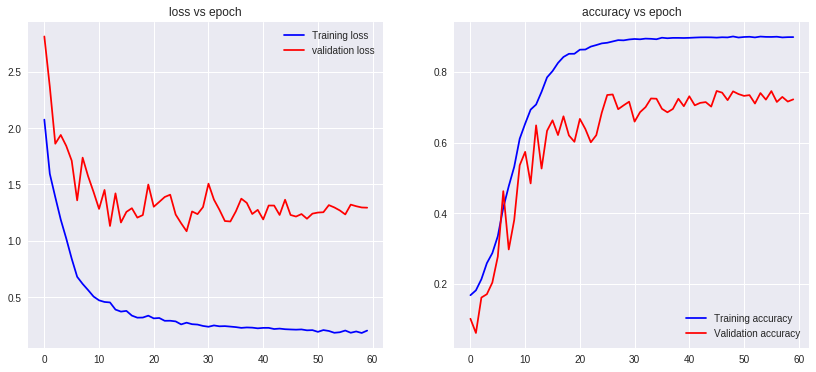

In [ ]:
plot_process(history_radius)